# Anomaly Detection

These are my notes & codes from the lecture: Unsupervised Learning, Recommenders, Reinforcement Learning given by DeepLearning.AI in Coursera. In this notebook I will explain the anomaly detection with numpy. You may find the original notebook [here]().

Data includes: X_train, X_val and y_val. 

- Find mean, variance from training set. 
- Calculate the p values from training set.
- Seelct the threshold epsilon using validation set:
    - Find p_val values from validation set. 
    - Get the range of p_val and create list of potential epsilon values.
    - Try each of the potential epsilon values to calculate the TP, FP and TN. Calculate F1 score. 
    - Find the threshold which gives the maximum F1 score. 
- Find the anomalies in training set using the selected epsilon value. 

Let's import the libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

We will use the training dataset to fit the Gaussian distribution. Then we will use validation dataset and known true y values to select the treshold. 

## Dataset

In [2]:
X_train = np.array([[3.8, 4.0], [5.6, 4.7], [6.3, 3], [2.9, 4.6], [3.2, 4.9], [8,6], [9,7], [6.5,7], [5,5], [4,3], [6,7], 
              [7.4, 9.5], [4,5], [3,7], [5,6], [14, 7], [3.8,4.6], [4, 5.5], [3,7.8], [5,7], [4,5], [8.5,1], [4,1.5], [3,2], [8,1], 
              [10,3], [6,6], [9,5], [3,1.2], [8.5,10], [7,4], [5,4], [3,7], [12,10.5], [7,8], [10,9.2]])

X_val = np.array([[3, 4.0], [5, 6], [6.1, 3.2], [1, 1.5], [4.6, 8], [7,9], [12,15], [4,7], [5,3], [3.5, 7], [14,2], [3, 9.5], 
                  [4,5.4], [3.2,3.4], [1,6.5], [13, 3.5], [12.5,6.4], [6.7, 12], [3.5,4.5], [4,9], [4,5], [8,1], [0.5,1.5], 
                  [3.1,5], [2,8.7], [9.1,3.4], [4,4], [8,12], [4,1], [11,10]])

y_val = np.array([0,0,0,0,0,0,1,0,0,0,1,0,
                  0,0,0,1,1,1,0,0,0,0,0,
                 0,0,0,0,1,0,0])

In [3]:
print(X_train.shape)
print(X_val.shape)
print(y_val.shape)

(36, 2)
(30, 2)
(30,)


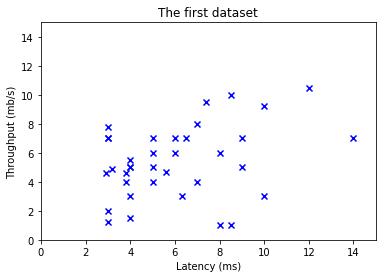

In [4]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 15, 0, 15])

plt.show()

## Calculate mean an variance using Numpy

If you have only 2 features, you can calculate/estimate mean value as follows:

In [5]:
data2 = np.array([[1,2],[4,8],[14,15]])
m, n = data2.shape
print(data2[:,0].sum()/m)
print(data2[:,1].sum()/m)

mu1 = np.array([data2[:,0].sum()/m, data2[:,1].sum()/m])

6.333333333333333
8.333333333333334


Or, you can get advantage of np.mean module:

In [6]:
mu2 = np.mean(data2, axis=0)
mu2

array([6.33333333, 8.33333333])

In [7]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    mu = np.mean(X, axis=0)
    var = np.mean((X-mu)**2, axis=0)
    return mu, var

In [8]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)

Mean of each feature: [6.04166667 5.38888889]
Variance of each feature: [7.52854167 6.0804321 ]


## Calculate p_val

In [9]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability 
    density function of the examples X under the multivariate gaussian 
    distribution with parameters mu and var. If var is a matrix, it is
    treated as the covariance matrix. If var is a vector, it is treated
    as the var values of the variances in each dimension (a diagonal
    covariance matrix
    """
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [10]:
def visualize_fit(X, mu, var):
    """
    This visualization shows you the 
    probability density function of the Gaussian distribution. Each example
    has a location (x1, x2) that depends on its feature values.
    """
    
    X1, X2 = np.meshgrid(np.arange(0, 20, 0.5), np.arange(0, 20, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)

    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

[0.01437701 0.02233177 0.01464769 0.01160346 0.01349121 0.01768254
 0.01062604 0.01873874 0.02161721 0.01115485 0.01899981 0.00518436
 0.01761434 0.01027897 0.02122577 0.00028315 0.01600785 0.01781667
 0.00788924 0.01768082 0.01761434 0.00323058 0.00514247 0.00494886
 0.0037409  0.00519717 0.02280922 0.01299177 0.00300614 0.00274066
 0.01888504 0.01867716 0.01027897 0.00025977 0.0126335  0.00251688]


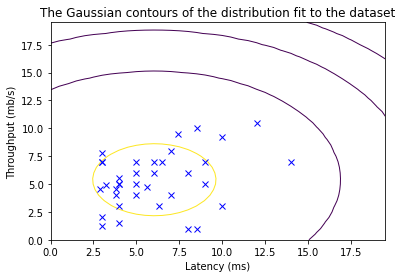

In [11]:
p = multivariate_gaussian(X_train, mu, var)
print(p)
visualize_fit(X_train, mu, var)

## Select the threshold $\epsilon$

We will use F1 score on cross validation set. 

If an example $x$ has a probability less than epsilon: $p(x) < \varepsilon$, then it is classified as an anomaly. 

prec = TP / (TP + FP)
recall = TP/ (TP + FN)

F1 = (2* prec* recall) / (prec + recall)

In [12]:
#example
p_val = np.array([0.2, 0.35, 0.9, 0.1, 0.5])
y_t = np.array([1,0,0,1,0])
ep = 0.4
pred = np.array(p_val<ep) 
pred

array([ True,  True, False,  True, False])

In [13]:
TP = ((pred == 1) & (y_t == 1)).sum()
FP = ((pred == 1) & (y_t == 0)).sum()
precision = TP / (TP+FP)
precision

0.6666666666666666

In [14]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        
        pred = np.array(p_val < epsilon)
        
        TP = ((pred == 1) & (y_val == 1)).sum()
        FP = ((pred == 1) & (y_val == 0)).sum()
        FN = ((pred == 0) & (y_val == 1)).sum()
        precision = TP / (TP+FP)
        recall = TP/ (TP+FN)
        
        F1 = (2 * precision * recall) / (precision + recall)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [15]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 7.227568e-04
Best F1 on Cross Validation Set: 0.909091


<ipython-input-14-fd63c684c3b9>:29: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP+FP)


## Find outliers on training set

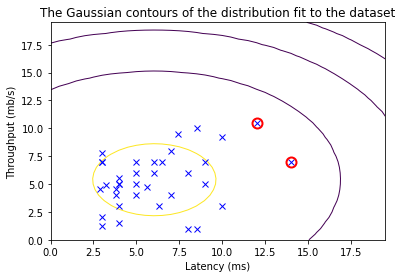

In [16]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)